# Adding contours of a surface region to a statistical map in Nilearn

I often use Nilearn's surface plotting to show a statistical map on the cortex - and wish that I could add the outlines of a region on top of the statistical map.
This is harder than it seems at the first thought, since matplotlib's mesh plotting allows us to only edit the whole color of a mesh-face, hence we need to find all faces that correspond to the outside edge of a region.

But here's code that's working for me.

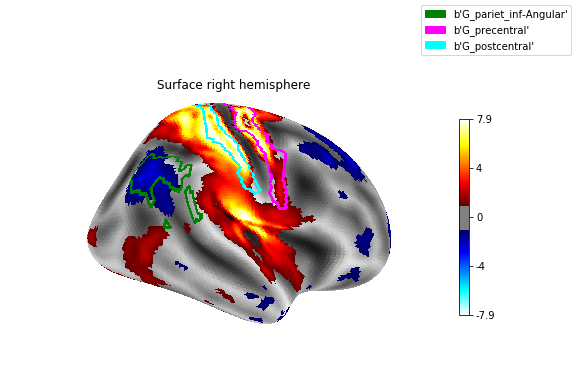

In [54]:
from nilearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
from nilearn.surface import load_surf_mesh
from matplotlib import colors as clr
import matplotlib.patches as mpatches

def get_faces(faces, parc_idx):
    '''Returns a boolean array indicating if a faces from lies on the outer edge of the parcellation defined by the indices in parc_idx
    IN:
    faces      -   numpy ndarray of shape (n, 3), containing indices of the mesh faces
    parc_idx   -   indices of the vertices belonging to the region that is to be plotted
    '''
    faces_in_parc = np.array([np.isin(face, parc_idx) for face in faces])
    vertices_on_edge = np.intersect1d(np.unique(faces[faces_in_parc.sum(axis=1)==2]), parc_idx)
    faces_outside_edge = np.array([np.isin(face, vertices_on_edge) for face in faces]).sum(axis=1)
    faces_outside_edge = np.logical_and(faces_outside_edge > 0, faces_in_parc.sum(axis=1)<3)
    return faces_outside_edge

def modify_facecolors(new_color, faces_to_modify, axes):
    '''Modifies colors of mesh in axes by replacing all faces in faces_to_modify with new_color'''
    if isinstance(new_color, str):
        new_color = np.array(clr.to_rgb(color)+(1.,))
    poly = axes.collections[0]
    fcolors = poly._facecolors3d
    fcolors[faces_outside] = np.array(new_color)
    poly._facecolors3d = fcolors
    return axes

# get a statistical map
motor_images = datasets.fetch_neurovault_motor_task()
stat_img = motor_images.images[0]
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface
texture = surface.vol_to_surf(stat_img, fsaverage.pial_right)
from nilearn import plotting

# and plot it on the fsaverage-surface
fig, axes = plt.subplots(1,1,subplot_kw={'projection':'3d'}, figsize=(9, 6))
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=1., bg_map=fsaverage.sulc_right, axes=axes)

# load vertex coordinates and face indices that specify the surface mesh
coords, faces = load_surf_mesh(fsaverage.infl_left)
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
parcellation = destrieux_atlas['map_right']

# these are the regions we want to outline
regions = [b'G_pariet_inf-Angular',
 b'G_precentral',  b'G_postcentral']
regions_idx = [np.where(np.array(destrieux_atlas['labels'])==region)[0]
               for region in regions]
colors = ['g', 'magenta', 'cyan']

patch_list = []
for reg_name, reg_i, color in zip(regions, regions_idx, colors):
    parc_idx = np.where(parcellation==reg_i)[0]
    faces_outside = get_faces(faces, parc_idx)
    modify_facecolors(color, faces_outside, axes)
    patch_list.append(mpatches.Patch(color=color, label=reg_name))
fig.legend(handles=patch_list)

## Let's test if we correctly outlined the regions

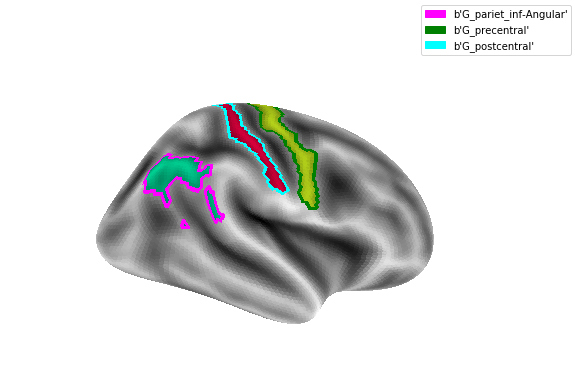

In [56]:
# let's create a parcellation consisting only of the regions we want to include
parc_cp = np.zeros_like(parcellation)
for i, reg in enumerate(regions_idx):
    parc_cp[parcellation==reg] = i+1

# create a surface ROI plot
fig, axes = plt.subplots(1,1,subplot_kw={'projection':'3d'}, figsize=(9, 6))
_=plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=parc_cp,
                         hemi='right', view='lateral', bg_map=fsaverage['sulc_right'], bg_on_data=True, axes=axes)

colors = ['magenta', 'g', 'cyan']

patch_list = []
for reg_name, reg_i, color in zip(regions, regions_idx, colors):
    parc_idx = np.where(parcellation==reg_i)[0]
    faces_outside = get_faces(faces, parc_idx)
    modify_facecolors(color, faces_outside, axes)
    patch_list.append(mpatches.Patch(color=color, label=reg_name))
fig.legend(handles=patch_list)